/home/doh16101/anaconda3/envs/CS330_torch/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Inside Linux
Not inside Colab
df_fold_1.shape (108872, 3)
df_fold_2.shape (108934, 3)
df_fold_1[y_true] == 3 Empty DataFrame
Columns: [table_file_name, y_pred, y_true, y_pred_prob_2, y_pred_prob_1, y_pred_prob_0]
Index: []
model 01 df_fold_1.shape (108586, 6) df_fold_2.shape (108909, 6)
[[174364   1996   3541]
 [   290  23126   1139]
 [  2626   2831   7582]]
TP [174364.  23126.   7582.]
FN [5537. 1429. 5457.]
Micro-averaged One-vs-Rest ROC AUC score:
0.50
Micro-averaged One-vs-Rest ROC AUC score:
0.50
Macro-averaged One-vs-Rest ROC AUC score:
0.50
Macro-averaged One-vs-Rest ROC AUC score:
0.50
Inside Linux
Not inside Colab
df_fold_1.shape (108872, 3)
df_fold_2.shape (108934, 3)
df_fold_1[y_true] == 3 Empty DataFrame
Columns: [table_file_name, y_pred, y_true, y_pred_prob_2, y_pred_prob_1, y_pred_prob_0]
Index: []
model 02 df_fold_1.shape (108586, 6) df_fold_2.shape (108909, 6)
[[171375   2647   5879]
 [   614  23210    731]
 [  2684   1938   8417]]
TP [171375.  23210.   8417.]
FN [8526.

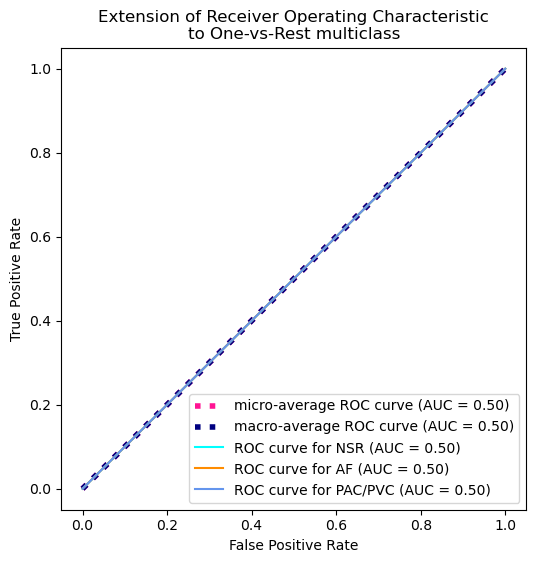

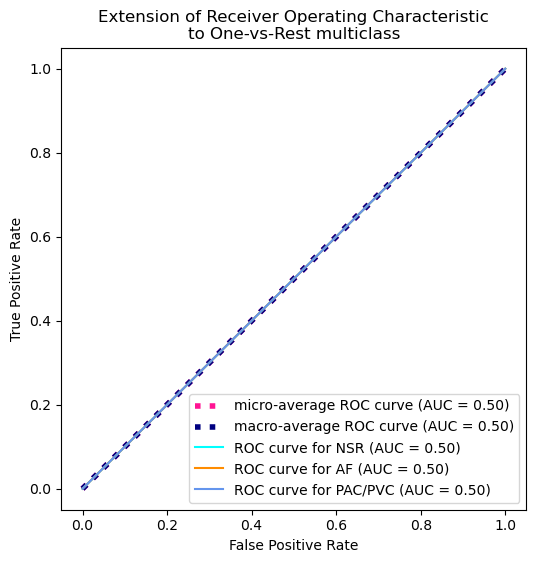

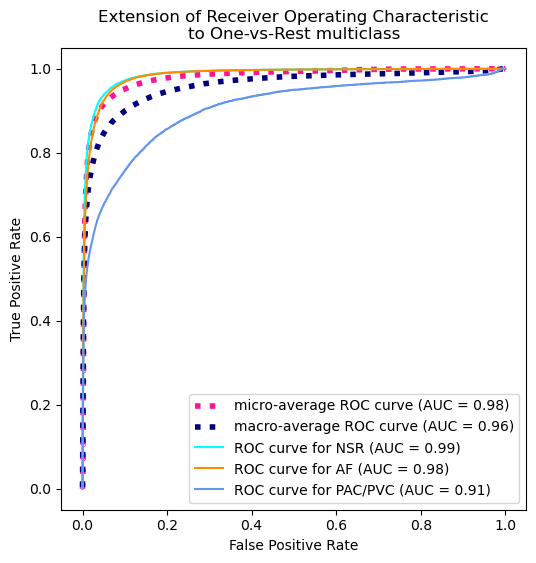

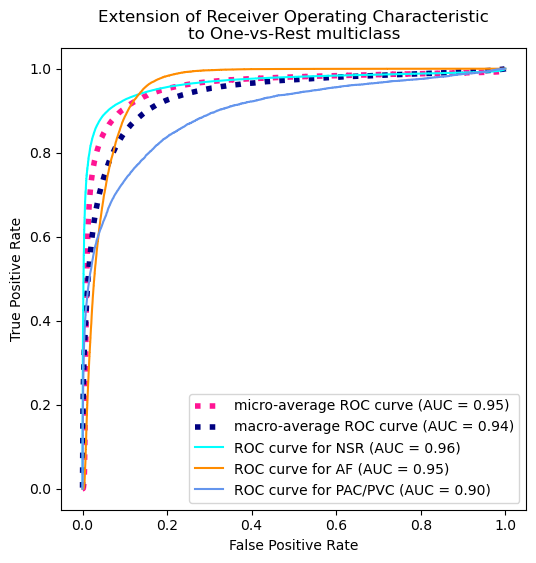

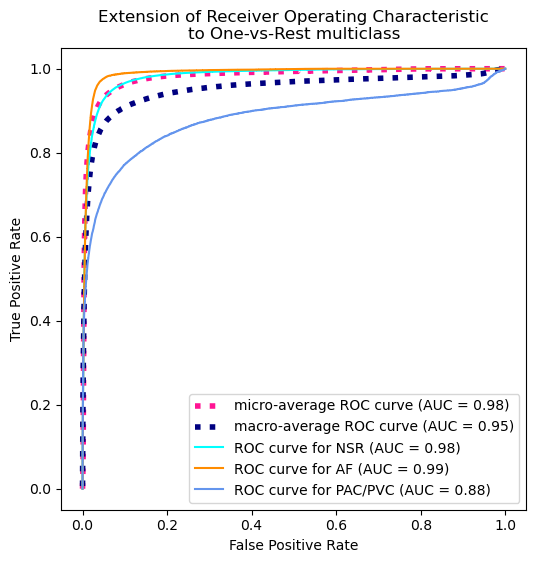

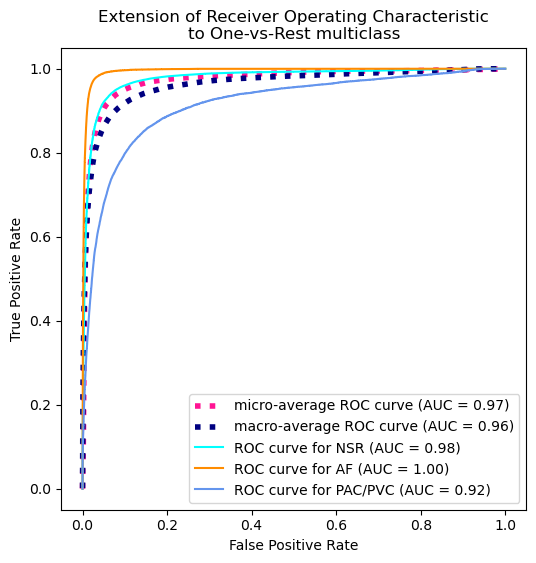

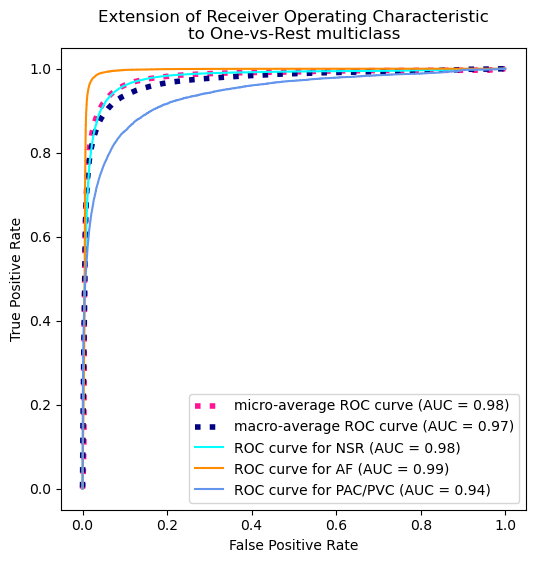

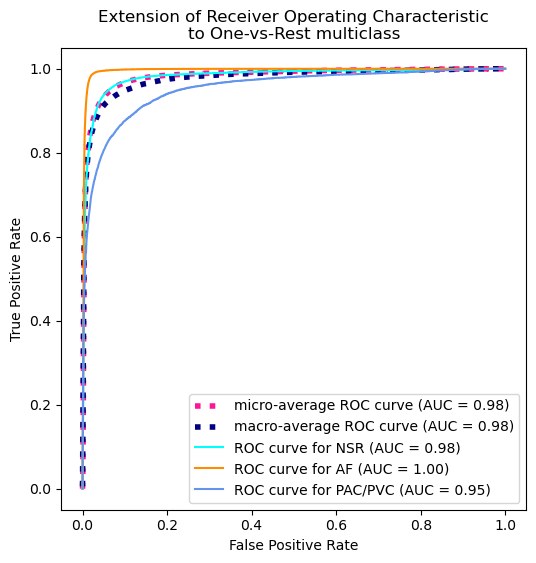

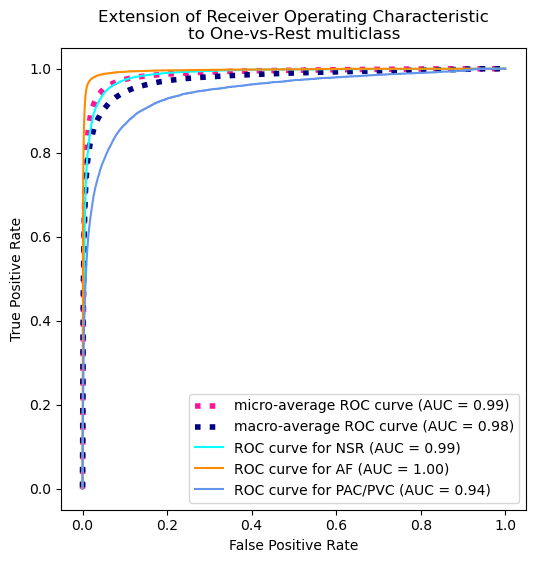

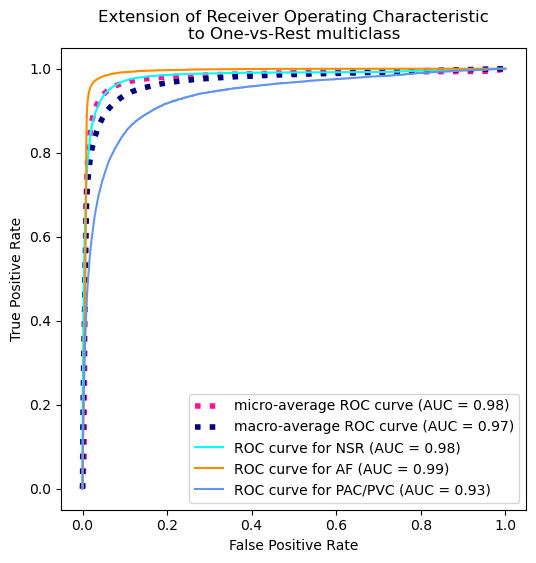

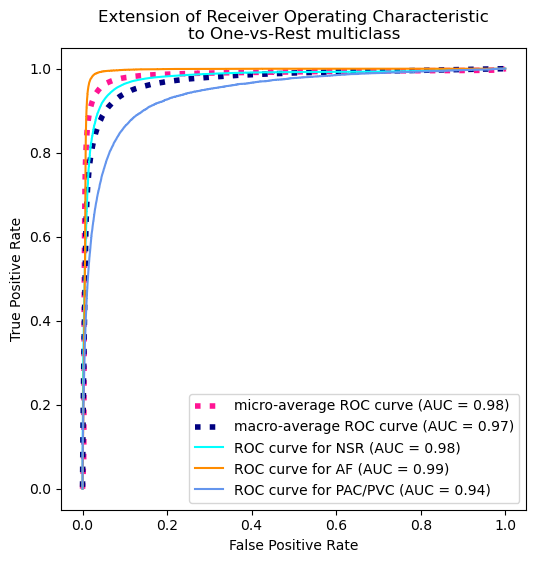

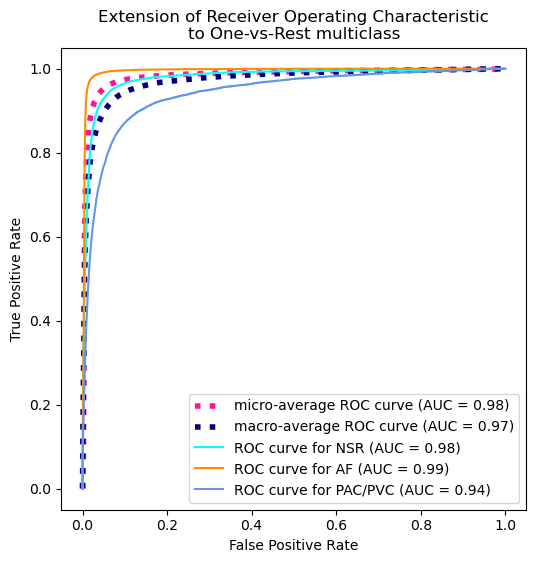

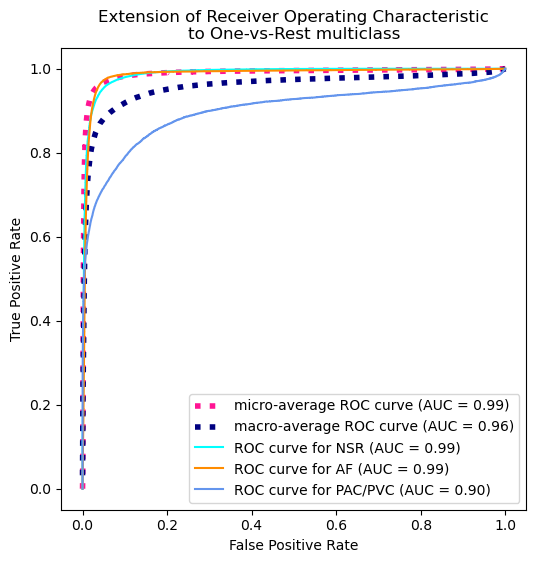

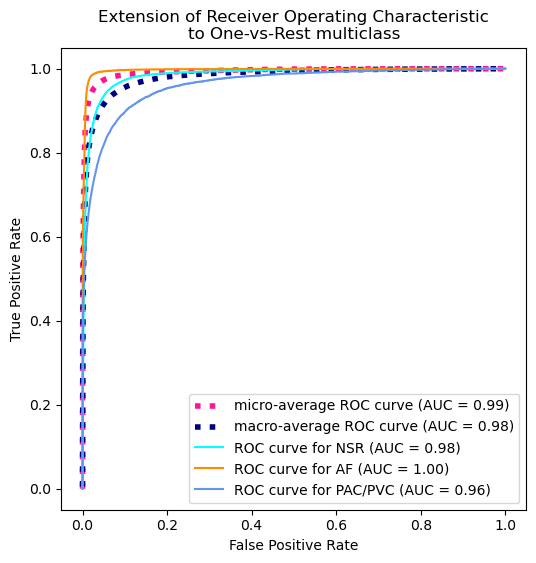

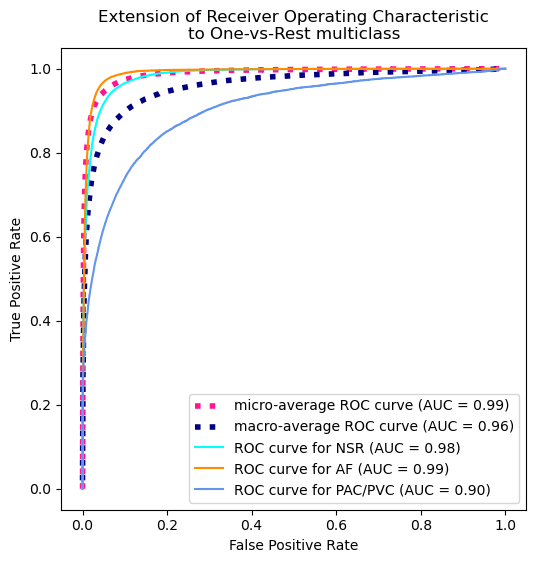

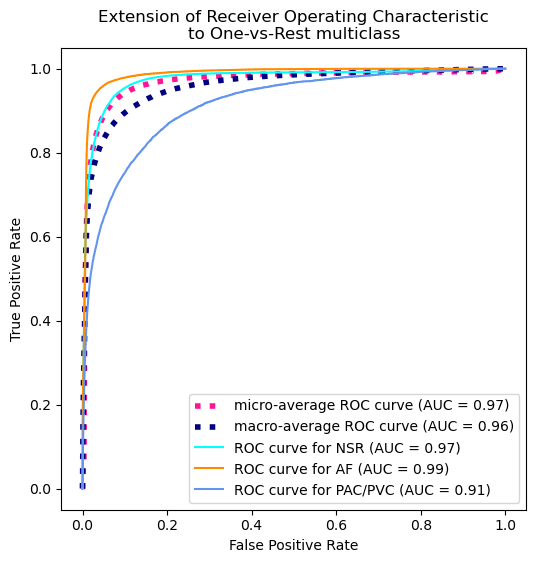

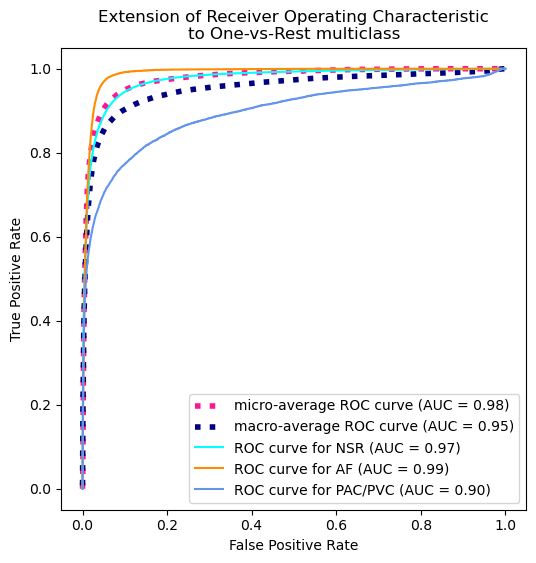

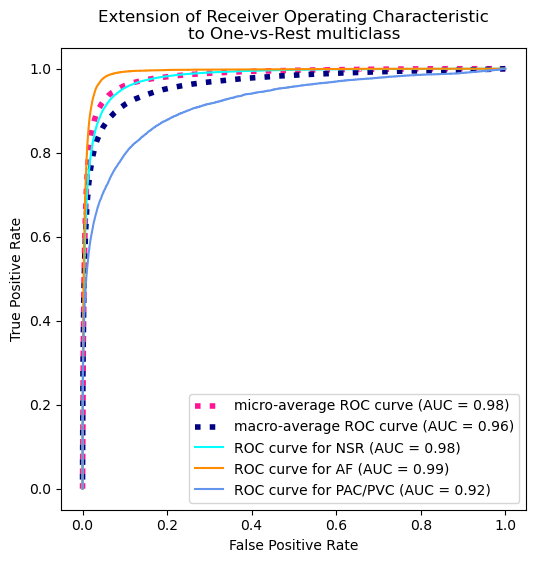

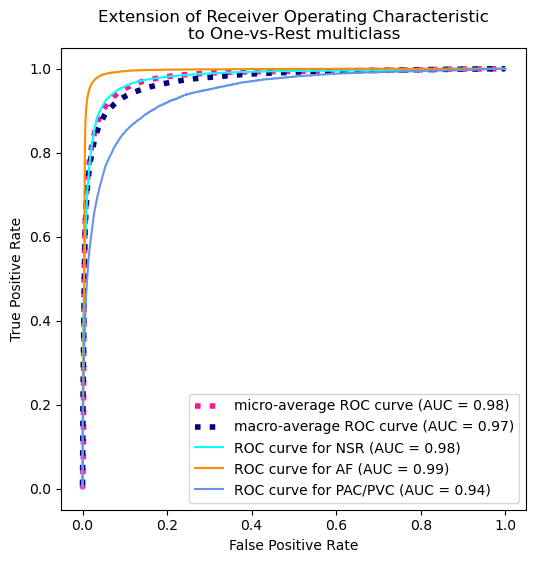

In [1]:
"""
Calculate the micro-AUROC from each fold plus the remaining NSR, and then average them.
Copied from:
/mnt/r/ENGR_Chon/Dong/Github_private/Pulsewatch_labeling/DeepBeat/experiments/try_07_eval_models/main_02_fold_1_2.py
"""
import os
import torch
import pandas as pd
import sys
import itertools
import pathlib
import numpy as np
# === Start of path and model name for all models. ===

# For 1D PPG aug5k:
# path_ckpt = r'/mnt/r/ENGR_Chon/Dong/Python_generated_results/deep_learning_2023/y_pred_2024_07_29_aug5k/TestRNNGRU_aug5k_PPG_HR_ACC_rescaleHR'
# file_date = '20240728'
# model_name = '1D_PPG_aug5k_HR_ACC_rescaleHR'
sys.path.append('/mnt/r/ENGR_Chon/Dong/Github_private/Pulsewatch_labeling/DeepBeat/experiments/try_07_eval_models')
import my_model_names
list_str_model_idx = ['01','02','03','04','05','06','07','08','09','10','11','12','18','19','20','21','22','23','24']
for str_model_idx in list_str_model_idx:
# if True:
    # str_model_idx = '20'
    path_ckpt, file_date, model_name = my_model_names.my_model_names(str_model_idx)
    # === End of path and model names. ====

    flag_linux = True
    flag_Colab = False
    # Append the directory to your python path using sys
    if flag_linux:
        print('Inside Linux')
        if flag_Colab:
            print('Inside Colab')
            # For 'my_pathdef'
        else:
            print('Not inside Colab')
            # For 'my_cfmatrix'
            sys.path.append('/mnt/r/ENGR_Chon/Dong/Github_private/Pulsewatch_labeling/DeepBeat/utils')
            import pretty_errors

    import my_cfmatrix

    # ====
    if str_model_idx == '01' or str_model_idx == '02':
        # TensorFlow model, so output saved in csv format.
        if str_model_idx == '01':
            filename_fold_1 = 'test_01_tfs_mm_fold_1.csv'
            filename_fold_2 = 'test_01_tfs_mm_fold_2.csv'
        else:
            filename_fold_1 = 'test_02_poin_mm_fold_1.csv'
            filename_fold_2 = 'test_02_poin_mm_fold_2.csv'

        df_fold_1 = pd.read_csv(os.path.join(path_ckpt,filename_fold_1))
        df_fold_2 = pd.read_csv(os.path.join(path_ckpt,filename_fold_2))

        print('df_fold_1.shape',df_fold_1.shape)
        print('df_fold_2.shape',df_fold_2.shape)
        df_fold_1_2_tfs = df_fold_1.merge(df_fold_2, how='outer', on='table_file_name', indicator = True)
        # Fold-1 and 2 combined results:
        # df_fold_1_results = df_fold_1_2_tfs.loc[(df_fold_1_2_tfs['_merge'] == 'left_only')]
        # df_fold_2_results = df_fold_1_2_tfs.loc[(df_fold_1_2_tfs['_merge'] == 'right_only')]

        y_pred_1 = df_fold_1_2_tfs['y_pred_x'].to_list()
        y_true_1 = df_fold_1_2_tfs['y_true_x'].to_list()
        y_pred_2 = df_fold_1_2_tfs['y_pred_y'].to_list()
        y_true_2 = df_fold_1_2_tfs['y_true_y'].to_list()

        df_fold_1 = pd.DataFrame({'table_file_name':df_fold_1_2_tfs['table_file_name'].to_list(),'y_pred':y_pred_1,'y_true':y_true_1})
        df_fold_2 = pd.DataFrame({'table_file_name':df_fold_1_2_tfs['table_file_name'].to_list(),'y_pred':y_pred_2,'y_true':y_true_2})

        # Remove SVT class:
        df_fold_1 = df_fold_1.loc[(df_fold_1['y_true'] == 0) | \
                            (df_fold_1['y_true'] == 1) | \
                            (df_fold_1['y_true'] == 2)] # Dong, 07/01/2024.
        df_fold_2 = df_fold_2.loc[(df_fold_2['y_true'] == 0) | \
                            (df_fold_2['y_true'] == 1) | \
                            (df_fold_2['y_true'] == 2)] # Dong, 07/01/2024.
        # Since 'y_pred_prob_0', 'y_pred_prob_1', 'y_pred_prob_2' are not in the table, I will fake one until I have them.
        df_fold_1.insert(3,'y_pred_prob_0',np.zeros((df_fold_1.shape[0],),dtype=float))
        df_fold_1.insert(3,'y_pred_prob_1',np.zeros((df_fold_1.shape[0],),dtype=float))
        df_fold_1.insert(3,'y_pred_prob_2',np.zeros((df_fold_1.shape[0],),dtype=float))
        df_fold_2.insert(3,'y_pred_prob_0',np.zeros((df_fold_2.shape[0],),dtype=float))
        df_fold_2.insert(3,'y_pred_prob_1',np.zeros((df_fold_2.shape[0],),dtype=float))
        df_fold_2.insert(3,'y_pred_prob_2',np.zeros((df_fold_2.shape[0],),dtype=float))

        print('df_fold_1[y_true] == 3',df_fold_1.loc[df_fold_1['y_true'] == 3])
    elif str_model_idx == '18' or str_model_idx == '19':
        fold_name = 'fold_1'
        filename_ckpt = 'test_02_Liu_JAHA_2022_the_other_fold_train_RNN_GRU_'+file_date+'_'+fold_name+'.pt'
        df_fold_1_fold = my_cfmatrix.my_load_pt_results(path_ckpt, filename_ckpt)

        fold_name = 'fold_2'
        filename_ckpt = 'test_02_Liu_JAHA_2022_the_other_fold_train_RNN_GRU_'+file_date+'_'+fold_name+'.pt'
        df_fold_2_fold = my_cfmatrix.my_load_pt_results(path_ckpt, filename_ckpt)

        fold_name = 'fold_1'
        filename_ckpt = 'test_03_Liu_JAHA_2022_remain_train_RNN_GRU_'+file_date+'_'+fold_name+'.pt'
        df_fold_1_NSR = my_cfmatrix.my_load_pt_results(path_ckpt, filename_ckpt)

        fold_name = 'fold_2'
        filename_ckpt = 'test_03_Liu_JAHA_2022_remain_train_RNN_GRU_'+file_date+'_'+fold_name+'.pt'
        df_fold_2_NSR = my_cfmatrix.my_load_pt_results(path_ckpt, filename_ckpt)

        path_output = '/'.join(path_ckpt.split('/')[:-1])
        df_fold_1 = pd.concat([df_fold_1_fold, df_fold_1_NSR], ignore_index=True, sort=False)
        df_fold_2 = pd.concat([df_fold_2_fold, df_fold_2_NSR], ignore_index=True, sort=False)
        df_fold_1_2_tfs = df_fold_1.merge(df_fold_2, how='outer', on='table_file_name', indicator = True)
    elif str_model_idx == '20':
        y_pred_filename_fold_1 = 'predictions_fold_1_other_fold_test_set.csv'
        y_pred_filename_fold_2 = 'predictions_fold_2_other_fold_test_set.csv'

        y_true_filename_fold_1 = 'labels_fold_1_other_fold_test_set.csv'
        y_true_filename_fold_2 = 'labels_fold_2_other_fold_test_set.csv'

        pred_prob_filename_fold_1 = 'prediction_proba_fold_1_other_fold_test_set.csv'
        pred_prob_filename_fold_2 = 'prediction_proba_fold_2_other_fold_test_set.csv'

        y_pred_fold_1 = pd.read_csv(os.path.join(path_ckpt,y_pred_filename_fold_1))
        y_pred_fold_2 = pd.read_csv(os.path.join(path_ckpt,y_pred_filename_fold_2))
        y_true_fold_1 = pd.read_csv(os.path.join(path_ckpt,y_true_filename_fold_1))
        y_true_fold_2 = pd.read_csv(os.path.join(path_ckpt,y_true_filename_fold_2))
        pred_prob_fold_1 = pd.read_csv(os.path.join(path_ckpt,pred_prob_filename_fold_1))
        pred_prob_fold_2 = pd.read_csv(os.path.join(path_ckpt,pred_prob_filename_fold_2))

        # print('y_pred_fold_1.columns',y_pred_fold_1.columns) # 'predictions'
        # print('y_true_fold_1.columns',y_true_fold_1.columns) # 'labels'
        # print('pred_prob_fold_1.columns',pred_prob_fold_1.columns) # '0', '1', '2'

        df_fold_1_fold = pd.DataFrame({'y_pred':y_pred_fold_1['predictions'].to_list(),
                                  'y_true':y_true_fold_1['labels'].to_list(),
                                  'y_pred_prob_0':pred_prob_fold_1['0'].to_list(),
                                  'y_pred_prob_1':pred_prob_fold_1['1'].to_list(),
                                  'y_pred_prob_2':pred_prob_fold_1['2'].to_list()})
        
        # print('df_fold_1',df_fold_1)

        df_fold_2_fold = pd.DataFrame({'y_pred':y_pred_fold_2['predictions'].to_list(),
                                  'y_true':y_true_fold_2['labels'].to_list(),
                                  'y_pred_prob_0':pred_prob_fold_2['0'].to_list(),
                                  'y_pred_prob_1':pred_prob_fold_2['1'].to_list(),
                                  'y_pred_prob_2':pred_prob_fold_2['2'].to_list()})
        
        # print('df_fold_2',df_fold_2)
        y_pred_filename_fold_1 = 'predictions_fold_1_remove_both_folds.csv'
        y_pred_filename_fold_2 = 'predictions_fold_2_remove_both_folds.csv'

        y_true_filename_fold_1 = 'labels_fold_1_remove_both_folds.csv'
        y_true_filename_fold_2 = 'labels_fold_2_remove_both_folds.csv'

        pred_prob_filename_fold_1 = 'prediction_proba_fold_1_remove_both_folds.csv'
        pred_prob_filename_fold_2 = 'prediction_proba_fold_2_remove_both_folds.csv'

        y_pred_fold_1 = pd.read_csv(os.path.join(path_ckpt,y_pred_filename_fold_1))
        y_pred_fold_2 = pd.read_csv(os.path.join(path_ckpt,y_pred_filename_fold_2))
        y_true_fold_1 = pd.read_csv(os.path.join(path_ckpt,y_true_filename_fold_1))
        y_true_fold_2 = pd.read_csv(os.path.join(path_ckpt,y_true_filename_fold_2))
        pred_prob_fold_1 = pd.read_csv(os.path.join(path_ckpt,pred_prob_filename_fold_1))
        pred_prob_fold_2 = pd.read_csv(os.path.join(path_ckpt,pred_prob_filename_fold_2))

        print('y_pred_fold_1.columns',y_pred_fold_1.columns) # 'predictions'
        print('y_true_fold_1.columns',y_true_fold_1.columns) # 'labels'
        print('pred_prob_fold_1.columns',pred_prob_fold_1.columns) # '0', '1', '2'

        df_fold_1_NSR = pd.DataFrame({'y_pred':y_pred_fold_1['predictions'].to_list(),
                                  'y_true':y_true_fold_1['labels'].to_list(),
                                  'y_pred_prob_0':pred_prob_fold_1['0'].to_list(),
                                  'y_pred_prob_1':pred_prob_fold_1['1'].to_list(),
                                  'y_pred_prob_2':pred_prob_fold_1['2'].to_list()})
        
        # print('df_fold_1',df_fold_1)

        df_fold_2_NSR = pd.DataFrame({'y_pred':y_pred_fold_2['predictions'].to_list(),
                                  'y_true':y_true_fold_2['labels'].to_list(),
                                  'y_pred_prob_0':pred_prob_fold_2['0'].to_list(),
                                  'y_pred_prob_1':pred_prob_fold_2['1'].to_list(),
                                  'y_pred_prob_2':pred_prob_fold_2['2'].to_list()})
        
        # print('df_fold_2',df_fold_2)
        df_fold_1 = pd.concat([df_fold_1_fold, df_fold_1_NSR], ignore_index=True, sort=False)
        df_fold_2 = pd.concat([df_fold_2_fold, df_fold_2_NSR], ignore_index=True, sort=False)
        # df_fold_1_2_tfs = df_fold_1.merge(df_fold_2, how='outer', on='table_file_name', indicator = True)
    else:
        fold_name = 'fold_1'
        filename_ckpt = 'test_02_the_other_fold_train_RNN_GRU_'+file_date+'_'+fold_name+'.pt'
        df_fold_1_fold = my_cfmatrix.my_load_pt_results(path_ckpt, filename_ckpt)

        fold_name = 'fold_2'
        filename_ckpt = 'test_02_the_other_fold_train_RNN_GRU_'+file_date+'_'+fold_name+'.pt'
        df_fold_2_fold = my_cfmatrix.my_load_pt_results(path_ckpt, filename_ckpt)

        path_output = '/'.join(path_ckpt.split('/')[:-1])

        fold_name = 'fold_1'
        filename_ckpt = 'test_03_remain_train_RNN_GRU_'+file_date+'_'+fold_name+'.pt'
        df_fold_1_NSR = my_cfmatrix.my_load_pt_results(path_ckpt, filename_ckpt)

        fold_name = 'fold_2'
        filename_ckpt = 'test_03_remain_train_RNN_GRU_'+file_date+'_'+fold_name+'.pt'
        df_fold_2_NSR = my_cfmatrix.my_load_pt_results(path_ckpt, filename_ckpt)

        path_output = '/'.join(path_ckpt.split('/')[:-1])

        df_fold_1 = pd.concat([df_fold_1_fold, df_fold_1_NSR], ignore_index=True, sort=False)
        df_fold_2 = pd.concat([df_fold_2_fold, df_fold_2_NSR], ignore_index=True, sort=False)

    print('model',str_model_idx,'df_fold_1.shape',df_fold_1.shape,'df_fold_2.shape',df_fold_2.shape)
    df_all = pd.concat([df_fold_1, df_fold_2], ignore_index=True, sort=False)
    # Calculate Sensitivity (TPR), Specificity (TNR), Precision (PPV), NPV, FPR, FNR, FDR, Accuracy (ACC).
    dict_metrics_all = my_cfmatrix.my_average_none_metrics(y_true = df_all['y_true'], y_pred = df_all['y_pred'])

    
    # Calculate the AUROC.
    n_classes = 3
    my_class_names = {0: 'NSR', 1: 'AF', 2: 'PAC/PVC'}
    test_name = 'AUROC_all_pulsewatch_subject_independent_test'
    path_output = os.path.join(r'/mnt/r/ENGR_Chon/Dong/Python_generated_results/deep_learning_2023/analysis_2024_07_30',test_name)
    path_output_fig = os.path.join(path_output,'plots')
    pathlib.Path(path_output_fig).mkdir(parents=True, exist_ok=True)
    micro_roc_auc_ovr, macro_roc_auc_ovr = my_cfmatrix.my_auroc_cal_plot(df_all, n_classes, my_class_names, path_output_fig, model_name, test_name, str_model_idx, fold_name='all')

    # Add new key value pair
    dict_metrics_all['micro_auroc'] = micro_roc_auc_ovr
    dict_metrics_all['macro_auroc'] = macro_roc_auc_ovr

    # df_metrics = pd.DataFrame(dict_metrics_avg.items(),columns=dict_metrics_avg.keys())
    df_metrics = pd.DataFrame.from_dict(dict_metrics_all, orient='columns').reset_index()
    df_metrics.to_csv(os.path.join(path_output,str_model_idx+'_'+model_name+'_'+test_name+'.csv'),header=True,index=True)